# Vectors

Let's play with different ways to compute word vectors!

In [2]:
from math import sqrt
from collections import Counter
import matplotlib.pyplot as plt
import torch
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_pretrained("bert-base-cased")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# please don't write one liners like this...
sherlock = tokenizer.encode(open("sherlock.txt").read()).tokens
ttc = tokenizer.encode(open("ttc.txt").read()).tokens

In [3]:
# always good to look at your data
Counter(sherlock + ttc).most_common(20)

[(',', 20785),
 ('.', 12807),
 ('the', 12683),
 ('and', 7672),
 ('of', 6615),
 ('to', 6256),
 ('“', 5656),
 ('a', 5504),
 ('”', 5092),
 ('I', 5032),
 ('in', 4388),
 ('that', 3485),
 ('was', 3157),
 ('-', 3093),
 ('his', 3045),
 ('it', 3024),
 ('he', 2641),
 ('you', 2422),
 ('’', 2214),
 ('had', 2118)]

In [20]:
VOCAB = sorted(set(sherlock + ttc))
tok2idx = {t: i for i, t in enumerate(VOCAB)}

print(len(VOCAB), "tokens in our vocab")
print(tok2idx)

11267 tokens in our vocab
{'!': 0, '##0': 1, '##1': 2, '##A': 3, '##AB': 4, '##AD': 5, '##AL': 6, '##AN': 7, '##AR': 8, '##AS': 9, '##AT': 10, '##B': 11, '##BE': 12, '##BL': 13, '##C': 14, '##CH': 15, '##CL': 16, '##CO': 17, '##D': 18, '##DA': 19, '##DE': 20, '##E': 21, '##EA': 22, '##EC': 23, '##ED': 24, '##EE': 25, '##EL': 26, '##EM': 27, '##EN': 28, '##EP': 29, '##ER': 30, '##ES': 31, '##ET': 32, '##F': 33, '##G': 34, '##GE': 35, '##H': 36, '##I': 37, '##IA': 38, '##ID': 39, '##IE': 40, '##IF': 41, '##IG': 42, '##II': 43, '##IL': 44, '##IM': 45, '##IN': 46, '##ION': 47, '##IP': 48, '##IS': 49, '##IT': 50, '##IVE': 51, '##K': 52, '##L': 53, '##LE': 54, '##LL': 55, '##MB': 56, '##ME': 57, '##N': 58, '##NC': 59, '##ND': 60, '##NE': 61, '##NG': 62, '##NT': 63, '##O': 64, '##OC': 65, '##OD': 66, '##OH': 67, '##OL': 68, '##ON': 69, '##OR': 70, '##OS': 71, '##PP': 72, '##Q': 73, '##R': 74, '##RB': 75, '##RE': 76, '##RO': 77, '##RS': 78, '##RT': 79, '##S': 80, '##SE': 81, '##SI': 82, '##SO'

## Term-Document Counts

Here, a vector has two dimensions \[count in sherlock, count in ttc\] which we plot (x, y). You can think of the vector as an arrow from (0, 0) to (x, y), or just the point (x, y).

In [4]:
sherlock_counts = Counter(sherlock)
ttc_counts = Counter(ttc)

In [5]:
def plot_words(words):
    x = [sherlock_counts.get(word, 0) for word in words]
    y = [ttc_counts.get(word, 0) for word in words]
    plt.figure()
    for i in range(len(words)):
        plt.plot([0, x[i]], [0, y[i]], label=words[i])
    lim = max(max(x), max(y)) + 5
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    plt.xlabel("Sherlock Holmes")
    plt.ylabel("Tale of Two Cities")
    plt.legend()
    plt.show()

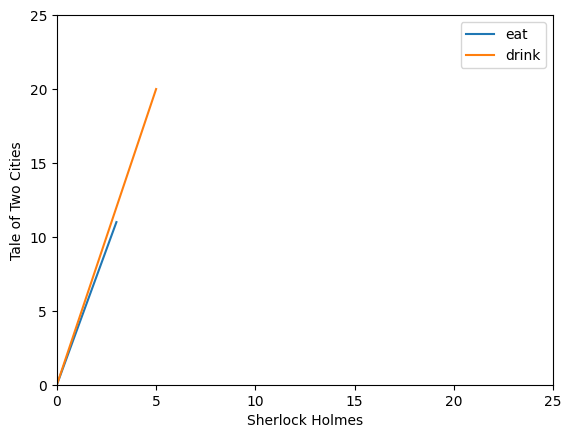

In [6]:
plot_words(["eat", "drink"])

In [ ]:
plot_words(["man", "woman"])

In [ ]:
plot_words(["go", "walk"])

## Co-occurrence Counts

In [10]:
def compute_cooc(word, tokens):
    cooc = []
    for i in range(5, len(tokens) - 5):
        if tokens[i] == word:
            left = tokens[i-5:i]
            right = tokens[i+1:i+6]
            cooc.append((left, right))
    return cooc


In [11]:
def display_cooc(word, cooc):
    lefts = [" ".join(left) for left, right in cooc]
    rights = [" ".join(right) for left, right in cooc]

    left_max = max(len(x) for x in lefts)
    right_max = max(len(x) for x in rights)

    for left, right in zip(lefts, rights):
        s = "{0:>" + str(left_max) + "s}  {1:s}  {2:" + str(right_max) + "s}"
        print(s.format(left, word, right))

In [12]:
word = "goose"
cooc = compute_cooc(word, sherlock + ttc)
display_cooc(word, cooc)

NameError: name 'sherlock' is not defined

In [9]:
def compute_cooc_counts(word):
    cooc = compute_cooc(word, sherlock + ttc)
    flattened = [word for pair in cooc for word in pair[0] + pair[1]]  # please don't write like this either...
    return Counter(flattened)

In [8]:
def dict2vec(d):
    """
    Convert a dictionary of counts to a vector of length |V|
    """
    vec = [0 for _ in range(len(VOCAB))]
    for token in d:
        vec[tok2idx[token]] = d[token]
    return vec


## Cosine similarity

In [5]:
def norm(vec):
    return sqrt(sum(x * x for x in vec))

In [6]:
def normalize(vec):
    denom = norm(vec)
    return [x / denom for x in vec]

In [7]:
def dot(a, b):
    assert len(a) == len(b)
    return sum(a[i] * b[i] for i in range(len(a)))

In [8]:
def cosine_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))
    # note: same as dot(normalize(b), normalize(a))

In [13]:
word1 = compute_cooc_counts("man")
word1 = dict2vec(word1)

word2 = compute_cooc_counts("woman")
word2 = dict2vec(word2)

cosine_sim(word1, word2)

NameError: name 'sherlock' is not defined

In [7]:
word1 = compute_cooc_counts("man")
word1 = dict2vec(word1)

word2 = compute_cooc_counts("boat")
word2 = dict2vec(word2)

cosine_sim(word1, word2)

NameError: name 'compute_cooc_counts' is not defined

## Make your own search engine

In [1]:
docs = ["doc 1 text ...", "doc 2 text ..."]
# convert docs to vectors

query = "some query"
# convert query to vector

scores = [(cosine_sim(query, doc), doc) for doc in docs]
sorted_docs = sorted(docs)

NameError: name 'cosine_sim' is not defined

## Intro to PyTorch

A tensor is one of the main objects in PyTorch. A 1D tensor is a vector (array), a 2D tensor is a matrix. Always be aware of the shape (dimensions) of your tensor.

Here is how to implement what we did above using the built-in functions in PyTorch.

In [1]:
x = torch.Tensor([1,2,3])  # one dimensional (i.e. a vector)
x.shape

NameError: name 'torch' is not defined

In [25]:
x = torch.Tensor([[1, 2, 3]])  # two dimensional tensor (a 1x3 matrix)
x.shape

torch.Size([1, 3])

In [6]:
t1 = torch.Tensor(word1)
t1.shape

NameError: name 'word1' is not defined

In [27]:
t2 = torch.Tensor(word2)
t2.shape

torch.Size([11267])

In [28]:
t1.norm()

tensor(751.1445)

In [29]:
torch.dot(t1, t2)

tensor(6676.)

In [30]:
torch.dot(t1, t2) / (torch.norm(t1) * torch.norm(t2))

tensor(0.6898)

In [32]:
torch.cosine_similarity(t1, t2)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [33]:
# this function expects a 2d tensor (1xN matrix)
# note the extra brackets around word1 and word2
torch.cosine_similarity(torch.Tensor([word1]), torch.Tensor([word2]))

tensor([0.6898])